<a href="https://colab.research.google.com/github/w4bo/2023-bbs-op-datamining/blob/main/materials/03-SparkBasics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Spark & initialize application

Run the following code to install Spark in your Colab environment.

In [83]:
!apt update
# !apt-get install software-properties-common -y
# !add-apt-repository ppa:webupd8team/java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!java -version
!rm spark-3.2.1-bin-hadoop2.7.tgz | true
!rm -rf /content/spark-3.2.1-bin-hadoop2.7 | true
!wget -q https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz
!tar xf spark-3.2.1-bin-hadoop2.7.tgz
!mkdir -p /content
!mv spark-3.2.1-bin-hadoop2.7 /content

!pip install -q findspark

Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
18 packages can be upgraded. Run 'apt list --upgradable' to see them.
openjdk version "11.0.20.1" 2023-08-24
OpenJDK Runtime Environment (build 11.0.20.1+1-post-Ubuntu-

In [84]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop2.7"
import findspark
findspark.init()
findspark.find() # Should return '/content/spark-3.2.1-bin-hadoop2.7'

'/content/spark-3.2.1-bin-hadoop2.7'

In [85]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .getOrCreate()
sc = spark.sparkContext

sc

<SparkContext master=local appName=Colab>

# Spark: working with RDDs

Check the documentation: [here](https://spark.apache.org/docs/latest/api/python/reference/pyspark.html#rdd-apis).

## Basics

In [86]:
# let's create a simple example
riddle1 = "over the bench the sheep lives under the bench the sheep dies"
riddle2 = ["over the bench the sheep lives", "under the bench the sheep dies"]

In [87]:
# create an RDD from the `riddle` string
rdd1 = sc.parallelize(riddle1.split(" "))
# each tuple of the RDD corresponds to a single word

print(rdd1)
# why is there no result returned?

ParallelCollectionRDD[186] at readRDDFromFile at PythonRDD.scala:274


In [88]:
# compute the RDD
print(rdd1.collect())

['over', 'the', 'bench', 'the', 'sheep', 'lives', 'under', 'the', 'bench', 'the', 'sheep', 'dies']


In [89]:
rdd2 = sc.parallelize(riddle2)
print(rdd2.collect())

['over the bench the sheep lives', 'under the bench the sheep dies']


## Transformations

In [90]:
# map: returns a new RDD by applying a function to each of the elements in the original RDD
rdd1.map(lambda s: s.upper()).collect()

['OVER',
 'THE',
 'BENCH',
 'THE',
 'SHEEP',
 'LIVES',
 'UNDER',
 'THE',
 'BENCH',
 'THE',
 'SHEEP',
 'DIES']

In [91]:
# flatMap: returns a new RDD by applying the function to every element of the parent RDD and then flattening the result
rdd2.flatMap(lambda s: s.split(" ")).collect()

['over',
 'the',
 'bench',
 'the',
 'sheep',
 'lives',
 'under',
 'the',
 'bench',
 'the',
 'sheep',
 'dies']

In [92]:
# filter: returns a new RDD containing only the elements in the parent RDD that satisfy the function inside filter
rdd1.filter(lambda s: s.startswith("u")).collect()

['under']

In [93]:
# distinct: returns a new RDD that contains only the distinct elements in the parent RDD
rdd1.distinct().collect()

['over', 'the', 'bench', 'sheep', 'lives', 'under', 'dies']

In [94]:
# groupByKey: groups the values for each key in the (key, value) pairs of the RDD into a single sequence
rdd1.map(lambda s: (s,1)).groupByKey().mapValues(list).collect()

# (first map converts to a key-value RDD)
# (mapValues is a map that operates only on the values - in this case, used to convert from ResultIterable to List for printing reasons)

[('over', [1]),
 ('the', [1, 1, 1, 1]),
 ('bench', [1, 1]),
 ('sheep', [1, 1]),
 ('lives', [1]),
 ('under', [1]),
 ('dies', [1])]

In [95]:
# reduceByKey: when called on a key-value RDD, returns a new dataset in which the values for each of its key are aggregated
rdd1.map(lambda s: (s,1)).reduceByKey(lambda x, y: x + y).collect()

[('over', 1),
 ('the', 4),
 ('bench', 2),
 ('sheep', 2),
 ('lives', 1),
 ('under', 1),
 ('dies', 1)]

In [96]:
# sortByKey: returns a new RDD with (key,value) pairs of parent RDD in sorted order according to the key
rdd1.map(lambda s: (s,1)).sortByKey().collect()

[('bench', 1),
 ('bench', 1),
 ('dies', 1),
 ('lives', 1),
 ('over', 1),
 ('sheep', 1),
 ('sheep', 1),
 ('the', 1),
 ('the', 1),
 ('the', 1),
 ('the', 1),
 ('under', 1)]

In [97]:
# join: starting from two RDD with (key, value1) and (key, value2) pairs, returns a new RDD with (key, (value1, value2)) pairs
rddA = sc.parallelize([(1, "A1"), (2, "A2"), (3, "A3")])
rddB = sc.parallelize([(1, "B1"), (2, "B2"), (4, "B4")])
rddA.join(rddB).collect()

[(2, ('A2', 'B2')), (1, ('A1', 'B1'))]

## Actions

In [98]:
# collect: returns a list that contains all the elements of the RDD
rdd1.collect()

['over',
 'the',
 'bench',
 'the',
 'sheep',
 'lives',
 'under',
 'the',
 'bench',
 'the',
 'sheep',
 'dies']

In [99]:
# count: returns the number of elements in the RDD
rdd1.count()

12

In [100]:
# reduce: aggregates the elements of the RDD using a function that takes two elements of the RDD as input and gives the result
sc.parallelize([1, 2, 3, 4, 5]).reduce( lambda x, y: x * y)

120

In [101]:
# take: returns the first n elements of RDD in the same order
rdd1.take(2)

['over', 'the']

In [102]:
# saveAsTextFile: saves the content of the RDD to a file
!rm -rf /content/rdd1 | true
rdd1.saveAsTextFile("rdd1")

## Examples

In [103]:
# Flatten the words beginning with the letter C
# - map: transform each string in upper case (remember: map returns a new RDD with the same cardinality)
# - filter: keep only the strings beginning with "C" (remember: filter returns a new RDD with the same or smaller cardinality)
# - flatMap: explode each string into its characters (remember: flatMap returns a new RDD with the any cardinality)
rdd1\
    .map(lambda s: s.upper())\
    .filter(lambda s: s.startswith("U"))\
    .flatMap(lambda s: list(s))\
    .collect()

['U', 'N', 'D', 'E', 'R']

In [104]:
# A simple word count
# - map: map each word to a tuple (word, 1); each tuple represent the count associate with a word
# - reduceByKey: group all the tuples with the same word and sum the counts
# - sortBy: sort tuples by count
rdd1\
    .map(lambda s: (s, 1))\
    .reduceByKey(lambda a, b: a + b)\
    .sortBy(lambda x: x[1], False)\
    .collect()

[('the', 4),
 ('bench', 2),
 ('sheep', 2),
 ('over', 1),
 ('lives', 1),
 ('under', 1),
 ('dies', 1)]

In [105]:
# Compute average length of words depending on their initial letter
# map: map each word to a key-value tuple (word, (wordLength, 1)), where the value is an object composed by two value: the length of the word and a 1
# reduceByKey: group all the tuples with the same word to 1) sum the lengths, and 2) sum the counts
# mapValues: divides the sums by the counts to compute the averages
# sortBy: sort tuples by averages
rdd1\
  .map(lambda s: (s[0], (len(s),1)))\
  .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))\
  .mapValues(lambda x: x[0]/x[1])\
  .sortBy(lambda x: x[1], False)\
  .collect()

[('b', 5.0),
 ('s', 5.0),
 ('l', 5.0),
 ('u', 5.0),
 ('o', 4.0),
 ('d', 4.0),
 ('t', 3.0)]

# Spark: working with DataFrames

Check the documentation: [here](https://spark.apache.org/docs/3.2.1/api/python/reference/api/pyspark.sql.DataFrame.html).

What is different from Pandas' DataFrames?

- Spark supports parallelization (Pandas doesn't), thus it's more suitable for big data processing
- Spark follows Lazy Execution, which means that a task is not executed until an action is performed (Pandas follows Eager Execution, which means task is executed immediately)
- Spark has immutability (Pandas has mutability)
- The data structure is similar, the APIs are different

In [106]:
!wget https://raw.githubusercontent.com/w4bo/handsOnDataPipelines/main/materials/datasets/housing.csv
df = spark.read.option("delimiter", ",").option("header", "true").csv("housing.csv")
df.show()

--2023-10-12 20:52:27--  https://raw.githubusercontent.com/w4bo/handsOnDataPipelines/main/materials/datasets/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1.4M) [text/plain]
Saving to: ‘housing.csv.1’

housing.csv.1       100%[===================>]   1.36M  --.-KB/s    in 0.08s   

2023-10-12 20:52:27 (18.0 MB/s) - ‘housing.csv.1’ saved [1423529/1423529]

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+---------

In [107]:
# Switching from Spark to Pandas
pandasDF = df.toPandas()
print(pandasDF)

      longitude latitude housing_median_age total_rooms total_bedrooms  \
0       -122.23    37.88               41.0       880.0          129.0   
1       -122.22    37.86               21.0      7099.0         1106.0   
2       -122.24    37.85               52.0      1467.0          190.0   
3       -122.25    37.85               52.0      1274.0          235.0   
4       -122.25    37.85               52.0      1627.0          280.0   
...         ...      ...                ...         ...            ...   
20635   -121.09    39.48               25.0      1665.0          374.0   
20636   -121.21    39.49               18.0       697.0          150.0   
20637   -121.22    39.43               17.0      2254.0          485.0   
20638   -121.32    39.43               18.0      1860.0          409.0   
20639   -121.24    39.37               16.0      2785.0          616.0   

      population households median_income median_house_value ocean_proximity  
0          322.0      126.0     

In [108]:
# Switching from Pandas to Spark
df = spark.createDataFrame(pandasDF)
df.show()

/content/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:371: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|          341300.0|       NEAR BAY|
|  -122.25|   37.85|              

In [109]:
# select: returns a new DataFrame with only selected columns (similar to a map on RDDs)
df.select('population','median_house_value').show()

+----------+------------------+
|population|median_house_value|
+----------+------------------+
|     322.0|          452600.0|
|    2401.0|          358500.0|
|     496.0|          352100.0|
|     558.0|          341300.0|
|     565.0|          342200.0|
|     413.0|          269700.0|
|    1094.0|          299200.0|
|    1157.0|          241400.0|
|    1206.0|          226700.0|
|    1551.0|          261100.0|
|     910.0|          281500.0|
|    1504.0|          241800.0|
|    1098.0|          213500.0|
|     345.0|          191300.0|
|    1212.0|          159200.0|
|     697.0|          140000.0|
|     793.0|          152500.0|
|     648.0|          155500.0|
|     990.0|          158700.0|
|     690.0|          162900.0|
+----------+------------------+
only showing top 20 rows



In [110]:
# select, similarly to a map, allows column values to be redefined
df.select(df.population,df.median_house_value/1000).show()
# put the operation within parenthesis and add .alias('median_house_value_in_K$')

+----------+---------------------------+
|population|(median_house_value / 1000)|
+----------+---------------------------+
|     322.0|                      452.6|
|    2401.0|                      358.5|
|     496.0|                      352.1|
|     558.0|                      341.3|
|     565.0|                      342.2|
|     413.0|                      269.7|
|    1094.0|                      299.2|
|    1157.0|                      241.4|
|    1206.0|                      226.7|
|    1551.0|                      261.1|
|     910.0|                      281.5|
|    1504.0|                      241.8|
|    1098.0|                      213.5|
|     345.0|                      191.3|
|    1212.0|                      159.2|
|     697.0|                      140.0|
|     793.0|                      152.5|
|     648.0|                      155.5|
|     990.0|                      158.7|
|     690.0|                      162.9|
+----------+---------------------------+
only showing top

In [111]:
# withColumn: used to manipulate (rename, change the value, convert the datatype)
# an existing column in a dataframe (or to create a new column) while keeping the rest intact
df.withColumn('median_house_value_in_K$',df.median_house_value/1000).show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+------------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|median_house_value_in_K$|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+------------------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|                   452.6|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|                   358.5|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|                   352.1|
|  -122.25|   37.85|  

In [112]:
# filter: returns a new DataFrame containing only the elements in the parent DataFrame that satisfy the function inside filter (as in RDDs)
# orderBY: orders the DataFrame by the selected column(s)
df.filter(df.population > 1000).orderBy(df.population.asc()).show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.12|   37.88|              35.0|     2785.0|         362.0|    1001.0|     363.0|       8.0448|          433300.0|       NEAR BAY|
|  -117.88|   34.14|              23.0|     2308.0|         322.0|    1001.0|     317.0|       7.5112|          355500.0|         INLAND|
|  -116.68|   33.16|              26.0|     1820.0|         374.0|    1001.0|     324.0|       2.1797|          156300.0|         INLAND|
|  -118.51|   34.27|              36.0|     2276.0|         429.0|    1001.0|     419.0|       4.1042|          252100.0|      <1H OCEAN|
|  -122.23|   37.82|              

In [113]:
# groupBy: returns a new DataFrame which is the result of an aggregation
df.groupBy(df.ocean_proximity).agg({'median_house_value': 'avg', '*': 'count'}).show()

+---------------+-----------------------+--------+
|ocean_proximity|avg(median_house_value)|count(1)|
+---------------+-----------------------+--------+
|         ISLAND|               380440.0|       5|
|     NEAR OCEAN|     249433.97742663656|    2658|
|       NEAR BAY|     259212.31179039303|    2290|
|      <1H OCEAN|     240084.28546409807|    9136|
|         INLAND|     124805.39200122119|    6551|
+---------------+-----------------------+--------+



In [114]:
# withColumnRenamed: rename a column
df.groupBy(df.ocean_proximity).agg({'*': 'count'}).withColumnRenamed("count(1)", "tot").show()

+---------------+----+
|ocean_proximity| tot|
+---------------+----+
|         ISLAND|   5|
|     NEAR OCEAN|2658|
|       NEAR BAY|2290|
|      <1H OCEAN|9136|
|         INLAND|6551|
+---------------+----+



In [115]:
# SQL queries can be run on a DataFrame
df.createOrReplaceTempView("housing")
spark.sql("select ocean_proximity, avg(median_house_value) as avg_price from housing group by ocean_proximity order by avg_price desc").show()

+---------------+------------------+
|ocean_proximity|         avg_price|
+---------------+------------------+
|         ISLAND|          380440.0|
|       NEAR BAY|259212.31179039303|
|     NEAR OCEAN|249433.97742663656|
|      <1H OCEAN|240084.28546409807|
|         INLAND|124805.39200122119|
+---------------+------------------+



# Exercise: creating a cube

You are working with two files:

- weather-stations.csv: it contains a list of weather stations that capture weather information every day of every year throughout the world
  - Each station is identified by a StationID
- weather-sample-10k.csv: it contains the data measured by a certain station on a certain date (a sample of 10k lines collected from the National Climatic Data Center of the USA)
  - Each weather measurenent is identified by a StationID and a Timestamp

Your goal is to create a single file representing the following cube and to run some queries through PowerBI.

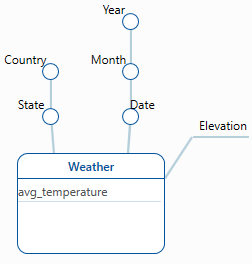

The procedure to create the cube is the following.

1. On the stations file:
  1. replace empty states and countries in stations with a placeholder value (e.g., "XX");
  1. keep only the following fields: stationId, state, country, elevation
2. On the weather-sample file:
  1. filter out weather wrong measurements (i.e., where airTemperatureQuality=9);
  1. keep only the following fields: stationId, airTemperature, date, month, year
  1. create a new fulldate field by concatenating year, month, and date
  1. create a new fullmonth field by concatenating year and month
1. Join stations with weather measurements on the stationId field
1. Keep only the following fields: state, country, elevation, fulldate, fullmonth, year, airTemperature
1. Aggregate the measurements by state and date to take the average temperature
  - Group by: state, country, elevation, fulldate, fullmonth, year
  - Calculation: avg(airTemperature)
1. Save the result on a file

In [116]:
!wget https://raw.githubusercontent.com/w4bo/2023-bbs-op-datamining/main/materials/datasets/weather-stations.csv
!wget https://raw.githubusercontent.com/w4bo/2023-bbs-op-datamining/main/materials/datasets/weather-sample-10k.txt

--2023-10-12 20:52:35--  https://raw.githubusercontent.com/w4bo/2023-bbs-op-datamining/main/materials/datasets/weather-stations.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2938813 (2.8M) [text/plain]
Saving to: ‘weather-stations.csv’

weather-stations.cs 100%[===================>]   2.80M  --.-KB/s    in 0.09s   

2023-10-12 20:52:36 (31.0 MB/s) - ‘weather-stations.csv’ saved [2938813/2938813]

--2023-10-12 20:52:36--  https://raw.githubusercontent.com/w4bo/2023-bbs-op-datamining/main/materials/datasets/weather-sample-10k.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTT

## Spark

In [117]:
dfW = sc.textFile("weather-sample-10k.txt")\
  .map(lambda l: (l[4:15],l[15:19],l[19:21],l[21:23],int(l[87:92])/10,l[92:93]))\
  .toDF(["stationId","year","month","day","airTemperature","airTemperatureQuality"])
dfW.show()

+-----------+----+-----+---+--------------+---------------------+
|  stationId|year|month|day|airTemperature|airTemperatureQuality|
+-----------+----+-----+---+--------------+---------------------+
|02924099999|2000|   08| 23|          11.3|                    1|
|02947099999|2000|   06| 11|          22.8|                    1|
|03002099999|2000|   01| 31|           4.4|                    1|
|03041099999|2000|   05| 17|           0.4|                    1|
|02935099999|2000|   06| 12|          10.1|                    1|
|02919099999|2000|   03| 31|           6.5|                    1|
|02913099999|2000|   10| 06|          12.0|                    1|
|03002099999|2000|   11| 11|           8.2|                    1|
|02944099999|2000|   09| 23|          -0.9|                    1|
|03014099999|2000|   04| 13|           3.8|                    1|
|02958099999|2000|   08| 13|         999.9|                    9|
|02970099999|2000|   07| 03|         999.9|                    9|
|028690999

In [118]:
from pyspark.sql.functions import concat
dfS = spark.read.option("delimiter", ",").option("header", "false").csv("weather-stations.csv")
dfS = dfS.select(concat(dfS[0],dfS[1]),dfS[2],dfS[3],dfS[4],dfS[5],dfS[6],dfS[7],dfS[8],dfS[9],dfS[10])\
  .toDF("stationId","city","country","state","call","latitude","longitude","elevation","date_begin","date_end")
dfS.show()

+-----------+----------+-------+-----+----+--------+---------+---------+----------+--------+
|  stationId|      city|country|state|call|latitude|longitude|elevation|date_begin|date_end|
+-----------+----------+-------+-----+----+--------+---------+---------+----------+--------+
|00700599999|CWOS 07005|   null| null|null|    null|     null|     null|  20120127|20120127|
|00701199999|CWOS 07011|   null| null|null|    null|     null|     null|  20120101|20121129|
|00701899999|WXPOD 7018|   null| null|null| +00.000| +000.000|  +7018.0|  20130710|20130730|
|00702599999|CWOS 07025|   null| null|null|    null|     null|     null|  20120127|20120127|
|00702699999|WXPOD 7026|     AF| null|null| +00.000| +000.000|  +7026.0|  20120713|20170715|
|00703499999|CWOS 07034|   null| null|null|    null|     null|     null|  20121024|20121106|
|00703799999|CWOS 07037|   null| null|null|    null|     null|     null|  20120726|20121125|
|00704499999|CWOS 07044|   null| null|null|    null|     null|     nul

1. On the stations file:
  1. replace empty states and countries in stations with a placeholder value (e.g., "XX");
  1. keep only the following fields: stationId, state, country, elevation

In [119]:
dfS1 = dfS.fillna({'state': 'XX', 'country':'XX'})
dfS2 = dfS1.select('stationId','state','country','elevation')
dfS2.show()

+-----------+-----+-------+---------+
|  stationId|state|country|elevation|
+-----------+-----+-------+---------+
|00700599999|   XX|     XX|     null|
|00701199999|   XX|     XX|     null|
|00701899999|   XX|     XX|  +7018.0|
|00702599999|   XX|     XX|     null|
|00702699999|   XX|     AF|  +7026.0|
|00703499999|   XX|     XX|     null|
|00703799999|   XX|     XX|     null|
|00704499999|   XX|     XX|     null|
|00704799999|   XX|     XX|     null|
|00705299999|   XX|     XX|     null|
|00705999999|   XX|     XX|     null|
|00706499999|   XX|     XX|     null|
|00707099999|   XX|     AF|  +7070.0|
|00707699999|   XX|     XX|     null|
|00708399999|   XX|     XX|     null|
|00708499999|   XX|     XX|     null|
|00709499999|   XX|     XX|     null|
|00826899999|   XX|     AF|  +1156.7|
|00840199999|   XX|     XX|     null|
|00840399999|   XX|     XX|     null|
+-----------+-----+-------+---------+
only showing top 20 rows



2. On the weather-sample file:
  1. filter out weather wrong measurements (i.e., where airTemperatureQuality=9);
  1. keep only the following fields: stationId, airTemperature, date, month, year
  1. create a new fulldate field by concatenating year, month, and date
  1. create a new fullmonth field by concatenating year and month

In [120]:
from pyspark.sql.functions import concat, lit
dfW1 = dfW.where("airTemperature < 9")
dfW2 = dfW1.select('stationId','airTemperature','day','month','year')
dfW3 = dfW2.withColumn("fulldate", concat(dfW1.year,lit("-"),dfW1.month,lit("-"),dfW1.day))
dfW4 = dfW3.withColumn("fullmonth", concat(dfW1.year,lit("-"),dfW1.month))
dfW4.show()

+-----------+--------------+---+-----+----+----------+---------+
|  stationId|airTemperature|day|month|year|  fulldate|fullmonth|
+-----------+--------------+---+-----+----+----------+---------+
|03002099999|           4.4| 31|   01|2000|2000-01-31|  2000-01|
|03041099999|           0.4| 17|   05|2000|2000-05-17|  2000-05|
|02919099999|           6.5| 31|   03|2000|2000-03-31|  2000-03|
|03002099999|           8.2| 11|   11|2000|2000-11-11|  2000-11|
|02944099999|          -0.9| 23|   09|2000|2000-09-23|  2000-09|
|03014099999|           3.8| 13|   04|2000|2000-04-13|  2000-04|
|02869099999|           0.0| 14|   04|2000|2000-04-14|  2000-04|
|02952099999|           4.0| 06|   02|2000|2000-02-06|  2000-02|
|02966099999|           2.0| 07|   02|2000|2000-02-07|  2000-02|
|02915099999|           2.3| 08|   01|2000|2000-01-08|  2000-01|
|02913599999|           0.0| 23|   11|2000|2000-11-23|  2000-11|
|03062099999|           5.5| 09|   04|2000|2000-04-09|  2000-04|
|03066099999|           4

3. Join stations with weather measurements on the stationId field


In [121]:
dfJ = dfS2.join(dfW4, "stationId")
dfJ.show()

+-----------+-----+-------+---------+--------------+---+-----+----+----------+---------+
|  stationId|state|country|elevation|airTemperature|day|month|year|  fulldate|fullmonth|
+-----------+-----+-------+---------+--------------+---+-----+----+----------+---------+
|03002099999|   XX|     UK|  +0015.0|           4.4| 31|   01|2000|2000-01-31|  2000-01|
|03041099999|   XX|     UK|  +1130.0|           0.4| 17|   05|2000|2000-05-17|  2000-05|
|02919099999|   XX|     FI|  +0077.0|           6.5| 31|   03|2000|2000-03-31|  2000-03|
|03002099999|   XX|     UK|  +0015.0|           8.2| 11|   11|2000|2000-11-11|  2000-11|
|02944099999|   XX|     FI|  +0118.9|          -0.9| 23|   09|2000|2000-09-23|  2000-09|
|03014099999|   XX|     UK|  +0013.0|           3.8| 13|   04|2000|2000-04-13|  2000-04|
|02869099999|   XX|     FI|  +0264.0|           0.0| 14|   04|2000|2000-04-14|  2000-04|
|02952099999|   XX|     FI|  +0013.4|           4.0| 06|   02|2000|2000-02-06|  2000-02|
|02966099999|   XX|  

4. Keep only the following fields: state, country, elevation, fulldate, fullmonth, year, airTemperature

In [122]:
dfJ2 = dfJ.select("state", "country", "elevation", "fulldate", "fullmonth", "year", "airTemperature")
dfJ2.show()

+-----+-------+---------+----------+---------+----+--------------+
|state|country|elevation|  fulldate|fullmonth|year|airTemperature|
+-----+-------+---------+----------+---------+----+--------------+
|   XX|     UK|  +0015.0|2000-01-31|  2000-01|2000|           4.4|
|   XX|     UK|  +1130.0|2000-05-17|  2000-05|2000|           0.4|
|   XX|     FI|  +0077.0|2000-03-31|  2000-03|2000|           6.5|
|   XX|     UK|  +0015.0|2000-11-11|  2000-11|2000|           8.2|
|   XX|     FI|  +0118.9|2000-09-23|  2000-09|2000|          -0.9|
|   XX|     UK|  +0013.0|2000-04-13|  2000-04|2000|           3.8|
|   XX|     FI|  +0264.0|2000-04-14|  2000-04|2000|           0.0|
|   XX|     FI|  +0013.4|2000-02-06|  2000-02|2000|           4.0|
|   XX|     FI|  +0103.3|2000-02-07|  2000-02|2000|           2.0|
|   XX|     FI|  +0132.0|2000-01-08|  2000-01|2000|           2.3|
|   XX|     FI|  +0026.0|2000-11-23|  2000-11|2000|           0.0|
|   XX|     UK|  +0004.0|2000-04-09|  2000-04|2000|           

5. Aggregate the measurements by state, country and date to take the average temperature
  - Group by: state, country, elevation, fulldate, fullmonth, year
  - Calculation: avg(airTemperature)

In [123]:
dfG = dfJ2.groupBy("state", "country", "elevation", "fulldate", "fullmonth", "year").agg({'airTemperature': 'avg'})
dfG.show()

+-----+-------+---------+----------+---------+----+-------------------+
|state|country|elevation|  fulldate|fullmonth|year|avg(airTemperature)|
+-----+-------+---------+----------+---------+----+-------------------+
|   XX|     UK|  +0015.0|2000-03-23|  2000-03|2000|                0.9|
|   XX|     FI|  +0013.4|2000-03-11|  2000-03|2000|               -6.3|
|   XX|     UK|  +0045.0|2000-12-24|  2000-12|2000|                4.4|
|   XX|     UK|  +0006.7|2000-11-20|  2000-11|2000|                2.0|
|   XX|     UK|  +0006.1|2000-02-22|  2000-02|2000|                6.0|
|   XX|     UK|  +0004.0|2000-03-03|  2000-03|2000|                1.1|
|   XX|     FI|  +0013.4|2000-01-02|  2000-01|2000|                1.0|
|   XX|     FI|  +0100.3|2000-01-15|  2000-01|2000|               -2.0|
|   XX|     UK|  +0018.0|2000-04-01|  2000-04|2000|                6.1|
|   XX|     FI|  +0106.4|2000-04-08|  2000-04|2000|                1.7|
|   XX|     FI|  +0264.0|2000-11-25|  2000-11|2000|             

6. Save the result on a file

In [124]:
dfG.write.mode('overwrite').option('header','true').csv("weather-cube")

## Power BI

Download the file from the left panel of this notebook (in case of issues, download it from [here](https://raw.githubusercontent.com/w4bo/2023-bbs-dm/master/materials/datasets/weather-cube.csv)) and load it in Power BI.
- (optional) Create the hierarchies
- Visualize the daily trend of average temperatures for each country
- Show the average temperature on the map
- Compute bins for the elevation field and show the average temperature for each bin


The final Power BI file will be available [here](https://raw.githubusercontent.com/w4bo/2023-bbs-dm/master/materials/results/weather-cube.pbix).

# Additional exercises

Carry out the following operations (in any order).

- Check if there exist stations with a negative elevation; then, calculate how many of these stations exist in each country; rename the result to "cnt" and order the result by decreasing cnt
- Take only stations with positive elevation, compute the maximum elevation by country and rename the result to "elevation"; then, join the result with the original dfS to get, for each country, the name of the city with the highest elevation (join key: ```["country","elevation"]```); order the result by decreasing elevation
- Take only weather values with airQuality==1, compute the minimum temperature for each stationId and rename it to "minTemperature"; then, join the result with dfS and keep only the columns "minTemperature" and "elevation"; finally, use the correlation between the two columns. To do the last part, you need to:
  - cast the elevation to an integer datatype: you need to add ```from pyspark.sql.types import IntegerType``` and then ```df.myfield.cast(IntegerType())```;
  - compute the correlation with ```df.stat.corr("myfield1","myfield2")```.

The solution will be available [here](https://raw.githubusercontent.com/w4bo/2023-bbs-dm/master/materials/results/03-SparkBasics-solution.ipynb).